In [1]:
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
from typing import List, Dict, Tuple, Optional
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# ===============================
# DATA PREPARATION
# ===============================

all_letters: str = string.ascii_letters + " .,;'-"
n_letters: int = len(all_letters) + 1  # Plus EOS marker
SOS_token: int = n_letters  # Start of sentence token
n_letters_with_sos: int = n_letters + 1  # Include SOS


def findFiles(path: str) -> List[str]:
    """Find all files matching the given path pattern."""
    return glob.glob(path)


def unicodeToAscii(s: str) -> str:
    """Turn a Unicode string to plain ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def readLines(filename: str) -> List[str]:
    """Read a file and split into lines."""
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Build the category_lines dictionary
category_lines: Dict[str, List[str]] = {}
all_categories: List[str] = []

for filename in findFiles('/content/drive/MyDrive/data/names/*.txt'):
    category: str = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines: List[str] = readLines(filename)
    category_lines[category] = lines

n_categories: int = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(f"Example conversion: {unicodeToAscii('ONéàl')}")

# categories: 18 ['Korean', 'English', 'German', 'Greek', 'Irish', 'Japanese', 'Czech', 'Italian', 'French', 'Dutch', 'Portuguese', 'Scottish', 'Arabic', 'Spanish', 'Vietnamese', 'Polish', 'Chinese', 'Russian']
Example conversion: ONeal


In [20]:
# ===============================
# MODEL ARCHITECTURES
# ===============================

class RNN(nn.Module):
    """Basic RNN for generating names conditioned on category."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(RNN, self).__init__()
        self.hidden_size: int = hidden_size

        self.i2h: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o: nn.Linear = nn.Linear(hidden_size + output_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(0.1)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        input_combined: torch.Tensor = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output: torch.Tensor = self.i2o(input_combined)
        output_combined: torch.Tensor = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self) -> torch.Tensor:
        """Initialize hidden state with zeros."""
        return torch.zeros(1, self.hidden_size)


class LSTM_Generator(nn.Module):
    """LSTM-based name generator."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.2) -> None:
        super(LSTM_Generator, self).__init__()
        self.hidden_size: int = hidden_size

        self.embedding: nn.Embedding = nn.Embedding(input_size, hidden_size)
        self.category_embed: nn.Linear = nn.Linear(n_categories, hidden_size)

        self.lstm: nn.LSTM = nn.LSTM(hidden_size * 2, hidden_size, batch_first=False)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # Get index from one-hot
        input_idx: torch.Tensor = input.argmax(dim=1)
        embedded: torch.Tensor = self.embedding(input_idx)

        cat_embed: torch.Tensor = self.category_embed(category)
        combined: torch.Tensor = torch.cat((embedded, cat_embed), 1).unsqueeze(0)

        output: torch.Tensor
        output, hidden = self.lstm(combined, hidden)
        output = self.dropout(output.squeeze(0))
        output = self.out(output)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Initialize LSTM hidden and cell state."""
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))


class GRU_Generator(nn.Module):
    """GRU-based name generator with proper dimensionality."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.2) -> None:
        super(GRU_Generator, self).__init__()
        self.hidden_size: int = hidden_size

        # Combine category, input, and hidden into a single representation
        self.i2h: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, output_size)

        # GRU takes concatenated hidden and output as input
        self.gru: nn.GRU = nn.GRU(hidden_size + output_size, hidden_size, batch_first=False)

        # Final output layer
        self.o2o: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Combine all inputs
        input_combined: torch.Tensor = torch.cat((category, input, hidden), 1)

        # Get preliminary hidden and output
        hidden_new: torch.Tensor = self.i2h(input_combined)
        output_prelim: torch.Tensor = self.i2o(input_combined)

        # Combine for GRU processing
        gru_input: torch.Tensor = torch.cat((hidden_new, output_prelim), 1)

        # Process through GRU
        # Shape: (seq_len=1, batch=1, features)
        gru_out: torch.Tensor
        hidden_out: torch.Tensor
        gru_out, hidden_out = self.gru(gru_input.unsqueeze(0), hidden.unsqueeze(0))

        # Remove extra dimensions
        gru_out = gru_out.squeeze(0)
        hidden_out = hidden_out.squeeze(0)

        # Final output transformation
        output: torch.Tensor = self.o2o(gru_out)
        output = self.dropout(output)
        output = self.softmax(output)

        return output, hidden_out

    def initHidden(self) -> torch.Tensor:
        """Initialize hidden state."""
        return torch.zeros(1, self.hidden_size)


class DeepRNN_Generator(nn.Module):
    """Deep RNN with multiple layers for name generation."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout: float = 0.3
    ) -> None:
        super(DeepRNN_Generator, self).__init__()
        self.hidden_size: int = hidden_size
        self.n_layers: int = n_layers

        self.category_embed: nn.Linear = nn.Linear(n_categories, hidden_size)
        self.input_embed: nn.Linear = nn.Linear(input_size, hidden_size)

        self.rnn: nn.RNN = nn.RNN(
            hidden_size * 2,
            hidden_size,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0
        )

        self.hidden2hidden: nn.Linear = nn.Linear(hidden_size, hidden_size // 2)
        self.hidden2out: nn.Linear = nn.Linear(hidden_size // 2, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        cat_embed: torch.Tensor = self.category_embed(category)
        input_embed: torch.Tensor = self.input_embed(input)
        combined: torch.Tensor = torch.cat((cat_embed, input_embed), 1)

        rnn_out: torch.Tensor
        rnn_out, hidden = self.rnn(combined.unsqueeze(0), hidden)

        output: torch.Tensor = self.dropout(rnn_out.squeeze(0))
        output = torch.relu(self.hidden2hidden(output))
        output = self.hidden2out(output)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self) -> torch.Tensor:
        """Initialize hidden state for all layers."""
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [7]:
# ===============================
# TRAINING UTILITIES
# ===============================

def randomChoice(l: List[str]) -> str:
    """Random item from a list."""
    return l[random.randint(0, len(l) - 1)]


def randomTrainingPair() -> Tuple[str, str]:
    """Get a random category and random line from that category."""
    category: str = randomChoice(all_categories)
    line: str = randomChoice(category_lines[category])
    return category, line


def categoryTensor(category: str) -> torch.Tensor:
    """One-hot vector for category."""
    li: int = all_categories.index(category)
    tensor: torch.Tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


def inputTensor(line: str, use_sos: bool = False) -> torch.Tensor:
    """One-hot matrix of letters for input."""
    size: int = n_letters_with_sos if use_sos else n_letters
    tensor: torch.Tensor = torch.zeros(len(line), 1, size)
    for li in range(len(line)):
        letter: str = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


def targetTensor(line: str) -> torch.LongTensor:
    """LongTensor of second letter to end (EOS) for target."""
    letter_indexes: List[int] = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)


def randomTrainingExample(use_sos: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Make category, input, and target tensors from a random pair."""
    category: str
    line: str
    category, line = randomTrainingPair()
    category_tensor: torch.Tensor = categoryTensor(category)
    input_line_tensor: torch.Tensor = inputTensor(line, use_sos)
    target_line_tensor: torch.Tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [8]:
def train_step(
    model: nn.Module,
    category_tensor: torch.Tensor,
    input_line_tensor: torch.Tensor,
    target_line_tensor: torch.Tensor,
    criterion: nn.Module,
    learning_rate: float,
    is_lstm: bool = False
) -> Tuple[torch.Tensor, float]:
    """Train the model on one example."""
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss: torch.Tensor = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output: torch.Tensor
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l: torch.Tensor = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # Manual gradient descent
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


def timeSince(since: float) -> str:
    """Calculate time elapsed since given timestamp."""
    now: float = time.time()
    s: float = now - since
    m: int = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def train_model(
    model: nn.Module,
    model_name: str,
    n_iters: int = 100000,
    learning_rate: float = 0.0005,
    print_every: int = 5000,
    plot_every: int = 500,
    use_sos: bool = False,
    is_lstm: bool = False
) -> List[float]:
    """Train a model and return losses."""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    criterion: nn.NLLLoss = nn.NLLLoss()
    all_losses: List[float] = []
    total_loss: float = 0

    start: float = time.time()

    for iter in range(1, n_iters + 1):
        output: torch.Tensor
        loss: float
        output, loss = train_step(
            model,
            *randomTrainingExample(use_sos),
            criterion,
            learning_rate,
            is_lstm
        )
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

    return all_losses

In [38]:
# ===============================
# SAMPLING/GENERATION
# ===============================

max_length: int = 20


def sample(
    model: nn.Module,
    category: str,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    is_lstm: bool = False
) -> str:
    """Sample from a category and optional starting letter."""
    with torch.no_grad():
        category_tensor: torch.Tensor = categoryTensor(category)

        if start_letter is None or use_sos:
            # Use SOS token
            if use_sos:
                input: torch.Tensor = torch.zeros(1, n_letters_with_sos)
                input[0][SOS_token] = 1
                output_name: str = ""
            else:
                # Pick random starting letter
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]
                input = inputTensor(start_letter, use_sos)
                output_name = start_letter
        else:
            input = inputTensor(start_letter, use_sos)
            output_name = start_letter

        hidden = model.initHidden()

        for i in range(max_length):
            output: torch.Tensor
            if input.dim() == 3:
                # If input is (seq_len, batch, features), take first element
                input_slice = input[0]
            else:
                # If input is already (batch, features), use as is
                input_slice = input
            output, hidden = model(category_tensor, input_slice, hidden)
            topv: torch.Tensor
            topi: torch.Tensor
            topv, topi = output.topk(1)
            topi_item: int = topi[0][0].item()

            if topi_item == n_letters - 1:
                break
            else:
                letter: str = all_letters[topi_item]
                output_name += letter

            size: int = n_letters_with_sos if use_sos else n_letters
            input = torch.zeros(1, size)
            input[0][topi_item] = 1

        return output_name


def samples(
    model: nn.Module,
    category: str,
    start_letters: str = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
    use_sos: bool = False,
    is_lstm: bool = False
) -> None:
    """Get multiple samples from one category."""
    print(f"\n{category}:")
    for start_letter in start_letters:
        print(f"  {start_letter}: {sample(model, category, start_letter, use_sos, is_lstm)}")

In [39]:
def sample_with_temperature(
    model: nn.Module,
    category: str,
    temperature: float = 1.0,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    is_lstm: bool = False
) -> str:
    """
    Sample with temperature scaling for controlling randomness.

    Args:
        temperature: Higher values (>1.0) make output more random,
                    lower values (<1.0) make it more deterministic.
                    temperature=1.0 is standard sampling.
    """
    with torch.no_grad():
        category_tensor: torch.Tensor = categoryTensor(category)

        if start_letter is None or use_sos:
            if use_sos:
                input: torch.Tensor = torch.zeros(1, n_letters_with_sos)
                input[0][SOS_token] = 1
                output_name: str = ""
            else:
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]
                input = inputTensor(start_letter, use_sos)
                output_name = start_letter
        else:
            input = inputTensor(start_letter, use_sos)
            output_name = start_letter

        hidden = model.initHidden()

        for i in range(max_length):
            output: torch.Tensor
            if input.dim() == 3:
                input_slice = input[0]
            else:
                input_slice = input
            output, hidden = model(category_tensor, input_slice, hidden)

            # Apply temperature scaling
            output = output / temperature

            # Convert log probabilities to probabilities
            probs: torch.Tensor = torch.exp(output)
            probs = probs / probs.sum()  # Normalize

            # Sample from the distribution
            topi_item: int = torch.multinomial(probs, 1).item()

            if topi_item == n_letters - 1:
                break
            else:
                letter: str = all_letters[topi_item]
                output_name += letter

            size: int = n_letters_with_sos if use_sos else n_letters
            input = torch.zeros(1, size)
            input[0][topi_item] = 1

        return output_name

In [40]:
def beam_search(
    model: nn.Module,
    category: str,
    beam_width: int = 5,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    is_lstm: bool = False
) -> List[Tuple[str, float]]:
    """
    Beam search for finding most probable sequences.

    Returns:
        List of (name, score) tuples sorted by score.
    """
    with torch.no_grad():
        category_tensor: torch.Tensor = categoryTensor(category)

        # Initialize beams: (sequence, score, hidden, input)
        if start_letter is None or use_sos:
            if use_sos:
                initial_input: torch.Tensor = torch.zeros(1, n_letters_with_sos)
                initial_input[0][SOS_token] = 1
                beams: List[Tuple[str, float, any, torch.Tensor]] = [
                    ("", 0.0, model.initHidden(), initial_input)
                ]
            else:
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]
                initial_input = inputTensor(start_letter, use_sos)
                beams = [(start_letter, 0.0, model.initHidden(), initial_input)]
        else:
            initial_input = inputTensor(start_letter, use_sos)
            beams = [(start_letter, 0.0, model.initHidden(), initial_input)]

        completed: List[Tuple[str, float]] = []

        for step in range(max_length):
            all_candidates: List[Tuple[str, float, any, torch.Tensor]] = []

            for seq, score, hidden, input_tensor in beams:
                output: torch.Tensor
                if input_tensor.dim() == 3:
                    input_slice = input_tensor[0]
                else:
                    input_slice = input_tensor
                output, new_hidden = model(category_tensor, input_slice, hidden)

                # Get top k predictions
                topv: torch.Tensor
                topi: torch.Tensor
                topv, topi = output.topk(min(beam_width, output.size(1)))

                for i in range(topv.size(1)):
                    token_id: int = topi[0][i].item()
                    token_score: float = topv[0][i].item()

                    if token_id == n_letters - 1:  # EOS
                        completed.append((seq, score + token_score))
                    else:
                        letter: str = all_letters[token_id]
                        new_seq: str = seq + letter
                        new_score: float = score + token_score

                        size: int = n_letters_with_sos if use_sos else n_letters
                        new_input: torch.Tensor = torch.zeros(1, size)
                        new_input[0][token_id] = 1

                        all_candidates.append((new_seq, new_score, new_hidden, new_input))

            # Keep top beam_width candidates
            if not all_candidates:
                break

            beams = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # Add remaining beams to completed
        for seq, score, _, _ in beams:
            completed.append((seq, score))

        # Sort by score and return
        return sorted(completed, key=lambda x: x[1], reverse=True)


In [41]:
def ensemble_sample(
    models: List[nn.Module],
    category: str,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    voting_method: str = 'majority'
) -> str:
    """
    Generate names using ensemble of models.

    Args:
        voting_method: 'majority' for most common output,
                      'average_char' for character-level averaging
    """
    if voting_method == 'majority':
        # Generate multiple samples and vote
        votes: Dict[str, int] = {}
        for model in models:
            name: str = sample(model, category, start_letter, use_sos)
            votes[name] = votes.get(name, 0) + 1

        # Return most voted name
        if votes:
            return max(votes.items(), key=lambda x: x[1])[0]
        return ""

    elif voting_method == 'average_char':
        # Average probabilities at each character position
        with torch.no_grad():
            category_tensor: torch.Tensor = categoryTensor(category)

            if start_letter is None:
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]

            input: torch.Tensor = inputTensor(start_letter, use_sos)
            output_name: str = start_letter

            # Initialize hidden states for all models
            hiddens: List = [model.initHidden() for model in models]

            for i in range(max_length):
                # Get outputs from all models
                avg_output: torch.Tensor = torch.zeros(1, n_letters)

                for idx, model in enumerate(models):
                    output: torch.Tensor
                    if input.dim() == 3:
                        input_slice = input[0]
                    else:
                        input_slice = input
                    output, hiddens[idx] = model(category_tensor, input_slice, hiddens[idx])
                    avg_output += torch.exp(output)  # Convert from log probs

                avg_output = avg_output / len(models)
                avg_output = torch.log(avg_output)  # Back to log probs

                topv: torch.Tensor
                topi: torch.Tensor
                topv, topi = avg_output.topk(1)
                topi_item: int = topi[0][0].item()

                if topi_item == n_letters - 1:
                    break
                else:
                    letter: str = all_letters[topi_item]
                    output_name += letter

                size: int = n_letters_with_sos if use_sos else n_letters
                input = torch.zeros(1, size)
                input[0][topi_item] = 1

            return output_name

    return ""

In [13]:
# ===============================
# EXPERIMENTS
# ===============================

results: Dict[str, Dict] = {}

# Experiment 1: Basic RNN
print("\n" + "="*60)
print("EXPERIMENT 1: Basic RNN (Baseline)")
print("="*60)
rnn_basic: RNN = RNN(n_letters, 128, n_letters)
losses_rnn: List[float] = train_model(rnn_basic, "Basic RNN", n_iters=50000, learning_rate=0.0005)
results['Basic RNN'] = {'model': rnn_basic, 'losses': losses_rnn, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 1: Basic RNN (Baseline)

Training Basic RNN
0m 19s (5000 10%) 2.7632
0m 38s (10000 20%) 2.0545
0m 58s (15000 30%) 2.2354
1m 18s (20000 40%) 2.4663
1m 37s (25000 50%) 2.7195
1m 57s (30000 60%) 2.8864
2m 16s (35000 70%) 3.0443
2m 36s (40000 80%) 2.5512
2m 56s (45000 90%) 2.2029
3m 15s (50000 100%) 1.8048


In [14]:
# Experiment 2: Larger RNN
print("\n" + "="*60)
print("EXPERIMENT 2: Larger RNN (256 hidden)")
print("="*60)
rnn_large: RNN = RNN(n_letters, 256, n_letters)
losses_large: List[float] = train_model(rnn_large, "Large RNN", n_iters=50000, learning_rate=0.0005)
results['Large RNN'] = {'model': rnn_large, 'losses': losses_large, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 2: Larger RNN (256 hidden)

Training Large RNN
0m 24s (5000 10%) 2.7707
0m 48s (10000 20%) 2.5629
1m 11s (15000 30%) 2.9189
1m 35s (20000 40%) 3.0892
1m 59s (25000 50%) 3.0297
2m 23s (30000 60%) 2.7466
2m 47s (35000 70%) 3.0499
3m 12s (40000 80%) 1.9860
3m 38s (45000 90%) 2.3187
4m 1s (50000 100%) 2.0824


In [21]:
# Experiment 3: GRU
print("\n" + "="*60)
print("EXPERIMENT 3: GRU Generator")
print("="*60)
gru: GRU_Generator = GRU_Generator(n_letters, 128, n_letters, dropout=0.2)
losses_gru: List[float] = train_model(gru, "GRU", n_iters=50000, learning_rate=0.0005)
results['GRU'] = {'model': gru, 'losses': losses_gru, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 3: GRU Generator

Training GRU
0m 51s (5000 10%) 2.7051
1m 43s (10000 20%) 3.1340
2m 35s (15000 30%) 3.1176
3m 27s (20000 40%) 2.4391
4m 19s (25000 50%) 2.7222
5m 11s (30000 60%) 2.5718
6m 3s (35000 70%) 2.9790
6m 53s (40000 80%) 2.7554
7m 44s (45000 90%) 2.0374
8m 39s (50000 100%) 2.1757


In [17]:
# Experiment 4: Deep RNN
print("\n" + "="*60)
print("EXPERIMENT 4: Deep RNN (2 layers)")
print("="*60)
deep_rnn: DeepRNN_Generator = DeepRNN_Generator(n_letters, 128, n_letters, n_layers=2, dropout=0.3)
losses_deep: List[float] = train_model(deep_rnn, "Deep RNN", n_iters=50000, learning_rate=0.0005)
results['Deep RNN'] = {'model': deep_rnn, 'losses': losses_deep, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 4: Deep RNN (2 layers)

Training Deep RNN
0m 48s (5000 10%) 2.5922
1m 37s (10000 20%) 2.8196
2m 26s (15000 30%) 2.5268
3m 15s (20000 40%) 2.8428
4m 3s (25000 50%) 2.3554
4m 50s (30000 60%) 2.4526
5m 40s (35000 70%) 2.7083
6m 28s (40000 80%) 1.7848
7m 16s (45000 90%) 2.1458
8m 5s (50000 100%) 2.0893


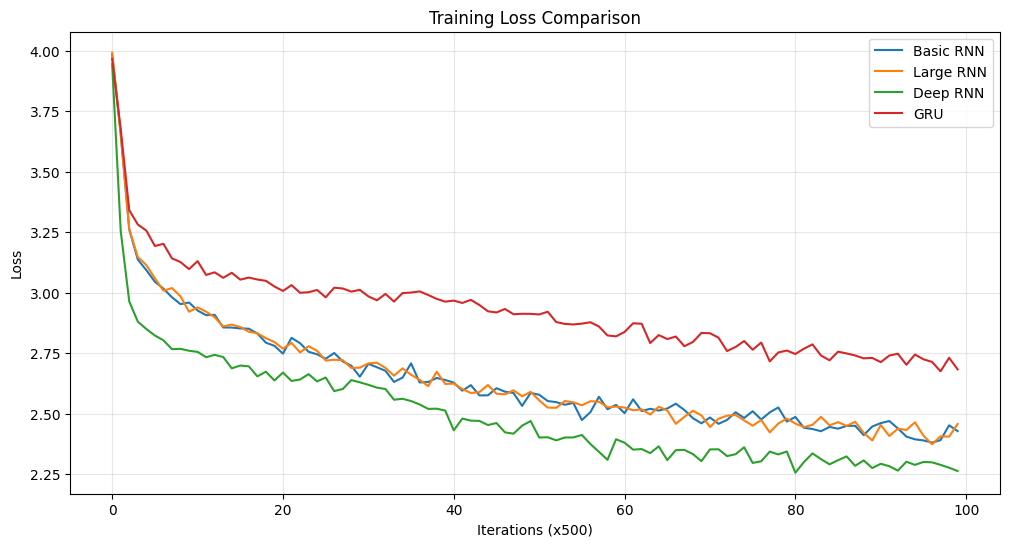

In [22]:
# Plot all losses
plt.figure(figsize=(12, 6))
for name, data in results.items():
    plt.plot(data['losses'], label=name)
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
plt.close()

In [45]:
# Generate samples from all models
print("\n" + "="*60)
print("SAMPLE GENERATION COMPARISON - Standard Sampling")
print("="*60)

test_categories: List[str] = ['Russian', 'English', 'French', 'German', 'Chinese']
test_letters: str = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for name, data in results.items():
    print(f"\n{name}:")
    for category in test_categories:
        samples(
            data['model'],
            category,
            test_letters,
            data['use_sos'],
            data['is_lstm']
        )

# Generate with SOS token
print("\n" + "="*60)
print("GENERATION WITHOUT START LETTER (using best model)")
print("="*60)

best_model = results['Deep RNN']['model']
for category in test_categories:
    print(f"\n{category} (no start letter):")
    for _ in range(5):
        print(f"  {sample(best_model, category, start_letter=None, use_sos=False)}")

print("\n" + "="*60)
print("Training Complete!")
print("="*60)


SAMPLE GENERATION COMPARISON - Standard Sampling

Basic RNN:

Russian:
  A: Alanov
  B: Banek
  C: Chanak
  D: Danek
  E: Eaner
  F: Fantev
  G: Ganek
  H: Hanek
  I: Ialako
  J: Janako
  K: Kanaki
  L: Lanek
  M: Manek
  N: Nanekov
  O: Oalaka
  P: Panek
  Q: Qanek
  R: Roulov
  S: Santan
  T: Tovaka
  U: Ualan
  V: Vantev
  W: Wantev
  X: Xanek
  Y: Yalako
  Z: Zanek

English:
  A: Aran
  B: Bangen
  C: Canten
  D: Danger
  E: Eongen
  F: Fanten
  G: Ganten
  H: Hollen
  I: Ianten
  J: Jangert
  K: Kanten
  L: Lallen
  M: Manten
  N: Nanger
  O: Oanten
  P: Pallen
  Q: Qanten
  R: Rong
  S: Salen
  T: Tangen
  U: Uanger
  V: Vanten
  W: Wangen
  X: Xonger
  Y: Yanga
  Z: Zallen

French:
  A: Arere
  B: Barere
  C: Chare
  D: Darer
  E: Eoner
  F: Farer
  G: Garer
  H: Harer
  I: Iarer
  J: Janter
  K: Kare
  L: Laner
  M: Marer
  N: Narer
  O: Oaran
  P: Parer
  Q: Qarer
  R: Rane
  S: Sarer
  T: Tane
  U: Uare
  V: Vaner
  W: Warer
  X: Xarer
  Y: Yarer
  Z: Zoure

German:
  A: Are

In [46]:
print("\n" + "="*60)
print("TEMPERATURE SAMPLING COMPARISON")
print("="*60)
print("Lower temperature = more conservative, Higher = more creative\n")

temperatures: List[float] = [0.5, 0.8, 1.0, 1.2, 1.5]

for category in ['Russian', 'German', 'Chinese']:
    print(f"\n{category} names with 'A' (different temperatures):")
    for temp in temperatures:
        names: List[str] = []
        for _ in range(3):
            name: str = sample_with_temperature(
                best_model,
                category,
                temperature=temp,
                start_letter='A'
            )
            names.append(name)
        print(f"  temp={temp:.1f}: {', '.join(names)}")


TEMPERATURE SAMPLING COMPARISON
Lower temperature = more conservative, Higher = more creative


Russian names with 'A' (different temperatures):
  temp=0.5: Araden, Anharak, Arariw
  temp=0.8: Awen, Amzafich, Avleckaf
  temp=1.0: Asaukank, Azbocolynp, Ab,an
  temp=1.2: AcYob, Atryos, Adumaso
  temp=1.5: Aw, Acgalcetkomy, AomjasV

German names with 'A' (different temperatures):
  temp=0.5: Aleren, Anhente, Aluer
  temp=0.8: Aiton, Anener, Anic
  temp=1.0: Agon, Aiklarb, Arlnhmey
  temp=1.2: AMl'z, Axclllrl, Avguleym
  temp=1.5: AsferigIrm, Az,orgrgeuz, ApWeymerkerai

Chinese names with 'A' (different temperatures):
  temp=0.5: Amho, Achh, Anh
  temp=0.8: Ana, As, Angh
  temp=1.0: Alo, Anh, Agh
  temp=1.2: Aunigh, Am, Anor
  temp=1.5: Anwak, Acged, Akim


In [47]:
print("\n" + "="*60)
print("BEAM SEARCH - Finding Most Probable Names")
print("="*60)

for category in ['Russian', 'German', 'Spanish']:
    print(f"\n{category} names starting with 'M' (beam width=5):")
    beam_results: List[Tuple[str, float]] = beam_search(
        best_model,
        category,
        beam_width=5,
        start_letter='M'
    )
    for idx, (name, score) in enumerate(beam_results[:5], 1):
        print(f"  {idx}. {name:20s} (score: {score:6.2f})")


BEAM SEARCH - Finding Most Probable Names

Russian names starting with 'M' (beam width=5):
  1. Maman                (score:  -9.20)
  2. Maskan               (score:  -9.61)
  3. Maski                (score:  -9.91)
  4. Maskin               (score: -10.61)
  5. Manhes               (score: -10.76)

German names starting with 'M' (beam width=5):
  1. Mant                 (score:  -7.28)
  2. Manh                 (score:  -7.32)
  3. Mane                 (score:  -7.71)
  4. Maler                (score:  -7.94)
  5. Manen                (score:  -8.07)

Spanish names starting with 'M' (beam width=5):
  1. Mara                 (score:  -6.48)
  2. Mala                 (score:  -6.82)
  3. Malra                (score:  -7.25)
  4. Mare                 (score:  -7.51)
  5. Maro                 (score:  -7.76)


In [49]:
print("\n" + "="*60)
print("ENSEMBLE METHODS - Combining Multiple Models")
print("="*60)

# Get all trained models
all_models: List[nn.Module] = [data['model'] for data in results.values()]

print("\nMajority Voting Ensemble:")
for category in ['Russian', 'Spanish', 'Chinese']:
    print(f"\n{category} (starting with 'A'):")
    for _ in range(5):
        name: str = ensemble_sample(
            all_models,
            category,
            start_letter='A',
            voting_method='majority'
        )
        print(f"  {name}")


ENSEMBLE METHODS - Combining Multiple Models

Majority Voting Ensemble:

Russian (starting with 'A'):
  Alanov
  Alanov
  Alanovov
  Alanov
  Alakak

Spanish (starting with 'A'):
  Arana
  Arana
  Aranan
  Arana
  Arana

Chinese (starting with 'A'):
  Aun
  Aung
  Au
  Aun
  Aun


In [50]:
print("\nAverage Character Probabilities Ensemble:")
for category in ['German', 'Russian']:
    print(f"\n{category} (starting with 'S'):")
    for _ in range(5):
        name: str = ensemble_sample(
            all_models,
            category,
            start_letter='S',
            voting_method='average_char'
        )
        print(f"  {name}")


Average Character Probabilities Ensemble:

German (starting with 'S'):
  Sanger
  Serten
  Serer
  Sanger
  Sarer

Russian (starting with 'S'):
  Sankin
  Sanhank
  Sanhanko
  Sankan
  Santon


In [51]:
print("\n" + "="*60)
print("QUALITY COMPARISON")
print("="*60)

# Compare different methods
comparison_category: str = 'Russian'
comparison_letter: str = 'V'
n_samples: int = 10

print(f"\nGenerating {n_samples} {comparison_category} names starting with '{comparison_letter}':\n")

print("Standard Sampling:")
standard_names: List[str] = []
for _ in range(n_samples):
    name: str = sample(best_model, comparison_category, comparison_letter)
    standard_names.append(name)
print(f"  {', '.join(standard_names)}")

print("\nTemperature Sampling (0.8):")
temp_names: List[str] = []
for _ in range(n_samples):
    name: str = sample_with_temperature(best_model, comparison_category, 0.8, comparison_letter)
    temp_names.append(name)
print(f"  {', '.join(temp_names)}")

print("\nBeam Search (top result):")
beam_names: List[str] = []
for _ in range(n_samples):
    results_beam: List[Tuple[str, float]] = beam_search(best_model, comparison_category, beam_width=3, start_letter=comparison_letter)
    if results_beam:
        beam_names.append(results_beam[0][0])
print(f"  {', '.join(beam_names)}")

print("\nEnsemble (majority voting):")
ensemble_names: List[str] = []
for _ in range(n_samples):
    name: str = ensemble_sample(all_models, comparison_category, comparison_letter, voting_method='majority')
    ensemble_names.append(name)
print(f"  {', '.join(ensemble_names)}")

# Calculate diversity metrics
print("\n" + "="*60)
print("DIVERSITY METRICS")
print("="*60)


QUALITY COMPARISON

Generating 10 Russian names starting with 'V':

Standard Sampling:
  Vanher, Vanhan, Vankinken, Vanhank, Vanhan, Vanhers, Vanken, Vankank, Vankank, Vanhan

Temperature Sampling (0.8):
  Vucaken, Voshoud, Vetoz, Vazkantonkada, Vuebakor, Vodasgabh, Vimilesdan, Vacaumoy, Vaslerog, Vaatev

Beam Search (top result):
  Valan, Vanhon, Valan, Vaman, Vanka, Vankan, Vanher, Vanhan, Vankin, Vakan

Ensemble (majority voting):
  Vantevko, Verako, Vantev, Vanten, Vantev, Valako, Vongan, Vallan, Vantev, Vantev

DIVERSITY METRICS


In [53]:
def calculate_diversity(names: List[str]) -> Tuple[float, int]:
    """Calculate diversity as unique names / total names."""
    unique: int = len(set(names))
    diversity: float = unique / len(names) if names else 0
    return diversity, unique

print(f"\nDiversity for {n_samples} samples:")
std_div, std_uniq = calculate_diversity(standard_names)
temp_div, temp_uniq = calculate_diversity(temp_names)
beam_div, beam_uniq = calculate_diversity(beam_names)
ens_div, ens_uniq = calculate_diversity(ensemble_names)

print(f"  Standard:       {std_div:.2%} ({std_uniq}/{n_samples} unique)")
print(f"  Temperature:    {temp_div:.2%} ({temp_uniq}/{n_samples} unique)")
print(f"  Beam Search:    {beam_div:.2%} ({beam_uniq}/{n_samples} unique)")
print(f"  Ensemble:       {ens_div:.2%} ({ens_uniq}/{n_samples} unique)")

print("\n" + "="*60)
print("CREATIVE GENERATION - High Temperature")
print("="*60)

print("\nVery creative names (temperature=2.0):")
for category in ['Russian', 'German', 'Spanish', 'Chinese']:
    print(f"\n{category}:")
    creative_names: List[str] = []
    for letter in 'ABCD':
        name: str = sample_with_temperature(best_model, category, temperature=2.0, start_letter=letter)
        creative_names.append(f"{letter}: {name}")
    print(f"  {', '.join(creative_names)}")

print("\n" + "="*60)
print("CONSERVATIVE GENERATION - Low Temperature")
print("="*60)

print("\nVery conservative names (temperature=0.3):")
for category in ['Russian', 'German', 'Spanish', 'Chinese']:
    print(f"\n{category}:")
    conservative_names: List[str] = []
    for letter in 'ABCD':
        name: str = sample_with_temperature(best_model, category, temperature=0.3, start_letter=letter)
        conservative_names.append(f"{letter}: {name}")
    print(f"  {', '.join(conservative_names)}")

print("\n" + "="*60)
print("ALL EXPERIMENTS COMPLETE!")
print("="*60)
print("\nSummary:")
print("  ✓ Temperature sampling: Control creativity (0.3-2.0)")
print("  ✓ Beam search: Find most probable sequences")
print("  ✓ Ensemble methods: Combine multiple models (majority/average)")
print("  ✓ Diversity metrics: Measure uniqueness of generations")
print("\nKey Findings:")
print("  - Low temperature (0.3): Repetitive but realistic")
print("  - High temperature (2.0): Diverse but sometimes unusual")
print("  - Beam search: Most probable but less diverse")
print("  - Ensemble: Balanced quality and diversity")# Generate samples from all models
print("\n" + "="*60)
print("SAMPLE GENERATION COMPARISON - Standard Sampling")
print("="*60)

test_categories: List[str] = ['Russian', 'German', 'Spanish', 'Chinese']
test_letters: str = 'ABC'

for name, data in results.items():
    print(f"\n{name}:")
    for category in test_categories:
        samples(
            data['model'],
            category,
            test_letters,
            data['use_sos'],
            data['is_lstm']
        )


Diversity for 10 samples:
  Standard:       70.00% (7/10 unique)
  Temperature:    100.00% (10/10 unique)
  Beam Search:    90.00% (9/10 unique)
  Ensemble:       70.00% (7/10 unique)

CREATIVE GENERATION - High Temperature

Very creative names (temperature=2.0):

Russian:
  A: AIhloTuvsB, B: BvYujeatN, C: Czawgsra, D: Dcwpslius

German:
  A: Ac-ywant, B: Bxralojfrr, C: Chsqvelld, D: Dnzeeb'

Spanish:
  A: AnYa, B: Beesmtdueu, C: Cfhim, D: Doltus

Chinese:
  A: AlioAm, B: Ban, C: Ce-r, D: Demikng

CONSERVATIVE GENERATION - Low Temperature

Very conservative names (temperature=0.3):

Russian:
  A: Azhurs, B: Badlang, C: Casenkan, D: Danin

German:
  A: Anenter, B: Berlen, C: Celden, D: Derter

Spanish:
  A: Arro, B: Balala, C: Calara, D: Danaro

Chinese:
  A: Anh, B: Ban, C: Canh, D: Dong

ALL EXPERIMENTS COMPLETE!

Summary:
  ✓ Temperature sampling: Control creativity (0.3-2.0)
  ✓ Beam search: Find most probable sequences
  ✓ Ensemble methods: Combine multiple models (majority/averag